In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
from scipy.linalg import block_diag
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from math import pi, sqrt
import time

In [2]:
def initialize_wf_2D(nx,ny,n_e):
    n_loc=np.zeros((ny,nx),dtype= 'int')        
    config=np.sort(random.sample(range(nx*ny),n_e))

    n_loc[np.floor(config/nx).astype(int),config%nx]=np.ones((n_e,))
    n_ind = np.zeros((ny,nx),dtype=int)        
    n_ind[np.floor(config/nx).astype(int),config%nx] = np.arange(1,n_e+1)
    
    return n_loc, config, n_ind

def wf_gen_2D(nx,ny,n_e,BCx,BCy,t):
    h1=np.ones(nx*ny-1)       # Hopping in +x direction
    h1[nx-1::nx]=0
    
    h2 = np.zeros(nx*ny-nx+1,dtype = 'complex') 
    h2[0::nx]=np.conj(BCx)    #Boundary condition for looping in -x-direction
    
    h3=np.ones(nx*ny-nx)      #  Hopping in +y direction
    
    h4=np.conj(BCy)*np.ones(nx,dtype = 'complex')# BC in -y direction
    
    hop= t*(np.diag(h1,1)+np.diag(h2,nx-1) + np.diag(h3,nx) + np.diag(h4,nx*ny-nx))
    
    H_t= -(hop+ np.matrix(hop).H)/2 
    
    energies, evecs= np.linalg.eigh(H_t)
    return evecs[:,:n_e]

def WF_MAT(wf_gen, config):
    n_e = len(config)
    wf = np.zeros((n_e,n_e),dtype = "complex")
    wf = np.transpose(wf_gen[config,:])
     
    return wf

In [3]:
def exact_renyi_calc(r,GA,epsilon=1e-9):
    chi0, _ =np.linalg.eigh(GA)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
#     return -np.sum((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))
    return np.sum(np.log((1-chi2)**r+chi2**r))/(1-r)


def exact_log_neg_calc(Na,Nb,GA,epsilon=1e-9):
    """computes log negativity of 1d free fermions"""
    Nt=Na+Nb

    Gm=np.eye(Nt)-2*GA
    Sp=np.array([[0,1],[0,0]])
    Gm_1=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,-1j*Gm[:Na,Na:])+np.kron(Sp.T,-1j*Gm[Na:,:Na])
    Gm_2=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,1j*Gm[:Na,Na:])+np.kron(Sp.T,1j*Gm[Na:,:Na])    
    Gx=np.dot(np.eye(Nt)-Gm_2,np.dot(np.linalg.inv(np.eye(Nt)+np.dot(Gm_1,Gm_2)),np.eye(Nt)-Gm_1))/2
    Gxh=(Gx+np.transpose(Gx).conj())/2

    chi0 =np.linalg.eigvalsh(Gxh)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    nu=chi1[i1]
    eA=np.sum(np.log(nu**0.5+(1-nu)**0.5))
    
    chi,VR=np.linalg.eigh(GA)
    sA=np.sum(np.log(chi**2+(1-chi)**2))/2    

    return eA+sA

def exact_Renyi_neg_calc2(r,Na,Nb,GA,epsilon=1e-9):
    """computes log negativity of 1d free fermions only works for even r"""
    Nt=Na+Nb

    Gm=np.eye(Nt)-2*GA
    Sp=np.array([[0,1],[0,0]])
    Gm_1=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,-1j*Gm[:Na,Na:])+np.kron(Sp.T,-1j*Gm[Na:,:Na])
    Gm_2=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,1j*Gm[:Na,Na:])+np.kron(Sp.T,1j*Gm[Na:,:Na])    
    Gx=np.dot(np.eye(Nt)-Gm_2,np.dot(np.linalg.inv(np.eye(Nt)+np.dot(Gm_1,Gm_2)),np.eye(Nt)-Gm_1))/2
    Gxh=(Gx+np.transpose(Gx).conj())/2

    chi0 =np.linalg.eigvalsh(Gxh)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    nu=chi1[i1]
    eA=np.sum(np.log(nu**(r/2)+(1-nu)**(r/2)))
    
    chi,VR=np.linalg.eigh(GA)
    sA=r*np.sum(np.log(chi**2+(1-chi)**2))/2    

    return eA+sA

def exact_Renyi_neg_calc(r,N,Na,Nb,V1):
    '''computes moments of partial transpose tr(\rho^T \rho^T\dag ... )
    for 1d free fermions ''' 
    k_sw=np.arange((-(r-1)/2),(r-1)/2+0.1,1)
    Zk=0
    if (r % 2) == 0:
        delta=pi
    else:
        delta= pi*(r-1)/r
#     delta=pi

    Nflip=Na+Nb
    N1=int((N-Nflip)/2)

    for i_k in range(len(k_sw)):
#         op_k=block_diag(np.eye(N1),np.exp(1j*2*pi/r*k_sw[i_k])*np.eye(Na),np.exp(1j*delta-1j*2*pi/r*k_sw[i_k])*np.eye(Nb),np.eye(N1))
        op_k=block_diag(np.exp(1j*2*pi/r*k_sw[i_k])*np.eye(Na),np.exp(1j*delta-1j*2*pi/r*k_sw[i_k])*np.eye(Nb),np.eye(N-Nflip))
        Zk +=np.real(np.log( np.linalg.det( np.dot(np.dot(np.matrix(V1).H,op_k),V1) )))
    return Zk

In [4]:
nx=4; ny = 2;
n_e= int(nx*ny/2)
BCx =1; BCy = 1
t = 1

n_loc,config,n_ind = initialize_wf_2D(nx,ny,n_e)    

print(n_loc)
print( config)
print( n_ind)

[[0 0 1 0]
 [0 1 1 1]]
[2 5 6 7]
[[0 0 1 0]
 [0 2 3 4]]


In [6]:
def run_negativity_2D(Orbitals, wf_r, config_r, n_loc_r, n_ind_r,nx,ny, n_e, n_configs, check_step,inds_A,inds_A1,inds_A2):
    
    move_attempted=0.0
    move_accepted=0.0
    i_up = (np.arange(r)+1)%r                             #Index shifted up by 1
    i_down = (np.arange(r)-1)%r                           #Index shifted down by 1

    n_i = np.arange(nx*ny)                                #Index for site on lattice (count accross x-axis before moving to y)
    x_loc = n_i%nx                                        #Indicies for location on x-axis
    y_loc = (n_i/nx).astype(int)                          #indicies for location on y-axis


    rel= np.zeros(((n_configs+min_state)*(check_step),n_e),dtype=complex)

    wf_inv_r = np.zeros(wf_r.shape,dtype=np.complex128)
    for i_r in range(r):                                   
        wf_inv_r[:,:,i_r]=np.linalg.inv(wf_r[:,:,i_r])

    count_ent=0                                           # counter for instances of calculated entropy
    count_neg=0                                           # counter for insttances of calcculated negativity
    ent_ratio=np.zeros(n_configs,dtype= np.complex128)    # VMC ratios for entropy calculations 
    neg_ratio=np.zeros(n_configs,dtype= np.complex128)    # VMC ratios for negativity calculations
    neg_ratio1=np.zeros(n_configs,dtype= np.complex128)   # VMC ratios for alternate negativity calculations

    step_abs=np.arange(1,n_hop+1)                         #possible steps of random walk
    step_vals=np.sort(np.concatenate((-step_abs,step_abs),axis=0)).tolist() #Makes a list of steps from -n_hop to n_hop

    for state in range(0,n_configs+min_state):            # Number of measurements
        for step in range(0,check_step):                  # Number of steps before measurement

            for i_r in range(r):                          # Iteration for each copy
                for moved_e in range(0,n_e):              # Move each electron individually           
                    move_attempted+=1

                    stepx=random.sample(step_vals,1)[0]   # Random step in the x direction
                    stepy=random.sample(step_vals,1)[0]   # Random step in the y direction

                    x_new = np.mod(x_loc[config_r[moved_e,i_r]]+stepx ,nx)    #New x-position
                    y_new = np.mod(y_loc[config_r[moved_e,i_r]]+stepy ,ny)    #New y-position
                    pts= nx*y_new+x_new                   # Random walk of with hops in (-n_hop,n_hop) on torus                   


                    if n_loc_r[y_new,x_new,i_r]==1:       # Ensure new location is unoccupied
                        continue

                    u_0 = np.transpose(Orbitals[pts,:] - Orbitals[config_r[moved_e,i_r],:])  # Difference in wf configurations for new and old e-location
                    r_det =  np.dot(Orbitals[pts,:],wf_inv_r[moved_e,:,i_r].reshape((n_e,1)))# Ratio of new to old slater det

                    rel[state*(check_step) + step,moved_e] = np.abs(r_det)**2                #ratio of probabilities

                    #accept_level = min(1,np.abs(r_det)**2) # Acceptance level for free fermions
                    accept_level = min(1,np.abs(r_det)**4)  # Acceptance level for Gutzwiller states

                    random_num = random.random()

                    if random_num < accept_level:
                        move_accepted += 1

                        #Sherman-Morisson Formula for updating inverse matrix
                        v=np.zeros((n_e,1))
                        v[moved_e]=1
                        num = np.dot(np.dot(np.dot(wf_inv_r[:,:,i_r],u_0),v.T),wf_inv_r[:,:,i_r])
                        denom = (1+np.dot(v.T,np.dot(wf_inv_r[:,:,i_r],u_0)))
                        wf_inv_r[:,:,i_r] = wf_inv_r[:,:,i_r] - num/denom 
                        wf_r[:,moved_e,i_r] = np.reshape(np.transpose(Orbitals[pts,:]),(n_e,))

                        delta= np.zeros((ny,nx))
                        delta[y_loc[config_r[moved_e,i_r]],x_loc[config_r[moved_e,i_r]]] = -1
                        delta[y_loc[pts],x_loc[pts]]=1

                        n_loc_r[:,:,i_r] = n_loc_r[:,:,i_r] + delta              #Update e-location
                        n_ind_r[:,:,i_r] = n_ind_r[:,:,i_r] + (moved_e + 1)*delta#Update e-index
                        config_r[moved_e,i_r] = pts                              #Update configuration

                x=np.argwhere(n_loc_r[:,:,i_r]>0)
                assert len(x)== n_e, 'no of ptcle is %d' % (len(x))
                assert np.sum(n_loc_r[:,:,i_r])== n_e, 'n_occ anc ptcle is %d' % (np.sum(n_loc_r[:,i_r]))


    #########   Evaluation Below this line   ########
        if state> (min_state-1):

            number_pt_inside_A= np.sum(n_loc_r[inds_A][:],axis=0)      # number of particles within region A for each copy

            t_A1 = np.zeros(r,dtype = 'int')
            t_A2 = np.zeros(r,dtype = 'int')
            number_pt_inside_A1= np.sum(n_loc_r[inds_A1][:],axis=0);   t_A1 =number_pt_inside_A1
            number_pt_inside_A2= np.sum(n_loc_r[inds_A2][:],axis=0);   t_A2 =number_pt_inside_A2

            ratio_n = 1.0 + 0j
            ratio_n_nophase = 1.0 + 0j
            ratio_e = 1.0 + 0j
            phase_r = np.ones(r,dtype = np.complex128)                 # Fermionic phase for each copy
            wf_swap = np.zeros(wf_r[:,:,i_r].shape,dtype=np.complex128)# Swapped WF for negativity calculation
            wf_swap_ent = np.zeros(wf_r[:,:,i_r].shape,dtype=np.complex128)# Swapped wf for entropy calculation

            check_1 = number_pt_inside_A
            check_2 = number_pt_inside_A1[i_up]+number_pt_inside_A2[i_down]
            comparison = check_1 == check_2

            if np.max(number_pt_inside_A)==np.min(number_pt_inside_A):   #Calculation when occupancy in region A is identical for each copy
                for i_r in range(r):
                    Config_A1_up = np.argwhere( n_loc_r[:,:,i_up[i_r]][inds_A1]>0 ) 
                    Config_A1_up = np.reshape( Config_A1_up, (len(Config_A1_up),)).tolist()
                    Wf_inds_up = ( n_ind_r[:,:,i_up[i_r]][inds_A1][Config_A1_up] )-1         #Indicies of electrons in region A1 shifted up

                    Config_A2_down = np.argwhere( n_loc_r[:,:,i_down[i_r]][inds_A2]>0 )
                    Config_A2_down = np.reshape( Config_A2_down, (len(Config_A2_down),)).tolist()
                    Wf_inds_down = ( n_ind_r[ :,:,i_down[i_r]][inds_A2][Config_A2_down] )-1  #Indicies of electrons in region A2 shifted down

                    Config_AA = np.argwhere( n_loc_r[:,:,i_r][inds_A]>0 )
                    Config_AA = np.reshape( Config_AA, (len(Config_AA),)).tolist()
                    Wf_inds_AA= ( n_ind_r[:,:,i_r][inds_A][Config_AA]  )-1                   #Indicies of elecctrons in region A

                    Config_A_up = np.argwhere( n_loc_r[:,:,i_up[i_r]][inds_A]>0 )
                    Config_A_up = np.reshape( Config_A_up, (len(Config_A_up),)).tolist()
                    Wf_inds_A_up = ( n_ind_r[:,:,i_up[i_r]][inds_A][Config_A_up]  )-1        #Indicies of electrons in region A shifted up (for entropy calculation)

                    wf_swap_ent= np.copy(wf_r[:,:,i_r])                                      #Swapped wf for ent calculation
                    wf_swap_ent[:,Wf_inds_AA] = np.copy(wf_r[:,Wf_inds_A_up,i_up[i_r]])
                    ratio_e*=np.linalg.det(wf_swap_ent)/np.linalg.det(wf_r[:,:,i_r])         #VMC ratio of det's for entropy calc
                    count_ent+=1

                    if len(Wf_inds_AA) == len(Wf_inds_up)+len(Wf_inds_down):                 #Necessary condition for calculating negativity
                        wf_swap = np.copy(wf_r[:,:,i_r])
                        wf_swap[:,Wf_inds_AA[0:len(Wf_inds_up)]] = np.copy(wf_r[:,Wf_inds_up,i_up[i_r]]) #Shifting forward
                        wf_swap[:,Wf_inds_AA[len(Wf_inds_up):len(Wf_inds_up)+len(Wf_inds_down)]] = np.copy(wf_r[:,Wf_inds_down,i_down[i_r]]) #Shifting back
                    
                        #Calculation of fermionic phase: t_A1 = number_pt_indide_A1 - may be ignored for Gutzwiller states
                        phase_r[i_r] = (-1)**((-1)**(i_r)*((int(t_A2[i_down[i_r]])+int(t_A2[i_r]))%2)/2 +int((t_A2[i_r]+t_A2[i_down[i_r]])*(t_A1[i_r]+t_A1[i_up[i_r]])))

                        #ratio_n*=phase_r[i_r]*np.linalg.det(wf_swap)/np.linalg.det(wf_r[:,:,i_r])  #VMC ratio of det's for free fermion negativity calc
                        ratio_n*=np.linalg.det(wf_swap)**2/np.linalg.det(wf_r[:,:,i_r])**2  #VMC ratio of det's for Gutzwiller state negativity calc (phase_r[i_r]**2 = 1)
                        count_neg+=1

                    else: 
                        ratio_n= 0

            elif comparison.all():                   # Condition that occupation of A does not change for any copy upon swap
                for i_r in range(r):
                    config_A1_up = np.argwhere( n_loc_r[:,:,i_up[i_r]][inds_A1]>0 )
                    config_A1_up = np.reshape( config_A1_up, (len(config_A1_up),)).tolist()
                    wf_inds_up = ( n_ind_r[:,:,i_up[i_r]][inds_A1][config_A1_up] )-1

                    config_A2_down = np.argwhere( n_loc_r[:,:,i_down[i_r]][inds_A2]>0 )
                    config_A2_down = np.reshape( config_A2_down, (len(config_A2_down),)).tolist()
                    wf_inds_down = ( n_ind_r[ :,:,i_down[i_r]][inds_A2][config_A2_down] )-1

                    config_AA = np.argwhere( n_loc_r[:,:,i_r][inds_A]>0 )
                    config_AA = np.reshape( config_AA, (len(config_AA),)).tolist()
                    wf_inds_AA= ( n_ind_r[:,:,i_r][inds_A][config_AA]  )-1 

                    wf_swap = np.copy(wf_r[:,:,i_r])
                    wf_swap[:,wf_inds_AA[0:len(wf_inds_up)]] = np.copy(wf_r[:,wf_inds_up,i_up[i_r]]) #Shifting forward
                    wf_swap[:,wf_inds_AA[len(wf_inds_up):len(wf_inds_up)+len(wf_inds_down)]] = np.copy(wf_r[:,wf_inds_down,i_down[i_r]]) #Shifting back

                    #Calculation of fermionic phase: t_A1 = number_pt_indide_A1 - may be ignored for Gutzwiller states
                    phase_r[i_r] = (-1)**((-1)**(i_r)*((int(t_A2[i_down[i_r]])+int(t_A2[i_r]))%2)/2 +int((t_A2[i_r]+t_A2[i_down[i_r]])*(t_A1[i_r]+t_A1[i_up[i_r]])))

                    #ratio_n*=phase_r[i_r]*np.linalg.det(wf_swap)/np.linalg.det(wf_r[:,:,i_r])          #VMC ratio of det's for free fermion negativity calc
                    ratio_n*=(phase_r[i_r]**2)*np.linalg.det(wf_swap)**2/np.linalg.det(wf_r[:,:,i_r])**2#VMC ratio of det's for Gutzwiller state negativity calc (phase_r[i_r]**2 = 1)
                    count_neg+=1
                    ratio_e = 0

            else:
                ratio_n = 0
                ratio_e = 0

            neg_ratio[state -min_state] = ratio_n
            ent_ratio[state -min_state] = ratio_e

        if (state%500) ==0:
            for i_r in range(r):
                wf_inv_r[:,:,i_r]=np.linalg.inv(wf_r[:,:,i_r])   



    acc_ratio = move_accepted/move_attempted 

    #print("Negativity computed %d times" % (count_neg/r))
    print("Entropy is approximately " ,  (np.log(np.mean(ent_ratio))/(1-r)) ) 
    print("Negativity is approximately " , -(np.log(np.mean(neg_ratio))))
    #print("the acceptance rate=", acc_ratio)
    #print("Reduced Negativity is", np.log(np.mean(neg_ratio)/np.mean(ent_ratio))/(1-r))


    return(np.log(np.mean(neg_ratio)), np.log(np.mean(ent_ratio))/(1-r))

In [7]:
###########Initialization###############

nx = 4                          # Length of lattice in x-direction
ny = 4                          # Length of lattice in y-direction
n_e = np.int(nx*ny/2)           # Number of electrons
n_hop = 3                       # maximum length of random walk in both direcions

t = 1                           #Hopping strength
BCx= 1 #np.exp(1j*np.pi/3)     #Boundary condition in x-direction
BCy= 1 #np.exp(1j*np.pi/3)     #Boundary condition in y-direction
r=2                            #Moment of Renyi entropy/Negativity to be detected

Ly_list= np.arange(2,ny+1,2)  #y-length of subsystems checked, starting from 0'th site

Orbitals = wf_gen_2D(nx,ny,n_e,BCx,BCy,t)  #First n_e eigenstates
                                                                                                                 
n_configs = 100000              #Number of configurations evaluated (measurements made)
check_step =2                   #Number of cycles between evaluations
min_state = 5                   #Number of evaluation cycles before starting data collection

Rr_vmc=np.zeros(len(Ly_list), dtype=np.complex64)
Rr_ex=np.zeros(len(Ly_list)) # Renyi entropy
Nr_vmc=np.zeros((len(Ly_list),1), dtype=np.complex64)
Nr_ex=np.zeros(len(Ly_list)) # Renyi negativity

Gmat=np.dot(Orbitals,np.matrix(Orbitals).H)      #Density matrix fro full ground state

wf_r= np.zeros((n_e,n_e,r),dtype=np.complex64)   #Matrix of wf values on occupied sites
n_loc_r= np.zeros((ny,nx,r),dtype=int)           # (x,y) mapping of occupied sites for each copy
config_r= np.zeros((n_e,r),dtype=int)            # single-index location of all n_e electrons
n_ind_r = np.zeros((ny,nx,r),dtype=int)          # (x,y) mapping of occupied sites for each copy with electrons indexed
cond_r = np.zeros(r)                             # Conditional indicating how volatile the det of the wf is to small changes in basis terms

######################## Evaluation ######################
t_timer=time.time()
random.seed(time.time())

#Cycling through geometries where region A covers half of the torus (cut along the x-axis), with equal division into A1 and A2
for i_L in range(len(Ly_list)):
    
    Lsub=Ly_list[i_L]
    nx_A = nx                                    #x-length of region A (may be anything)
    ny_A = Lsub                                  #y-length of region A
    print('subsystem size = {} x {}'.format(nx_A,ny_A)) 
    n_i_A = np.arange(nx_A*ny_A)                  
    inds_A =  tuple([np.floor(n_i_A/nx_A).astype(int),n_i_A%nx_A]) #(x,y) indicies for sites in Region A

    ny_A1 = int(Lsub/2); ny_A2 = Lsub-int(Lsub/2)
    n_i_A1 = np.arange(nx_A*ny_A1)
    n_i_A2 = np.arange(nx_A*ny_A2)
    inds_A1 =  tuple([np.floor(n_i_A1/nx_A).astype(int),n_i_A1%nx_A])            #(x,y) indicies for rectanglar Region A1 of dimension nx_A x (ny_A1)
    inds_A2 =  tuple([ny_A1+np.floor(n_i_A2/nx_A).astype(int),n_i_A2%nx_A])      #(x,y) indicies for adjecent Region A2 of dimension nx_A x (ny_A2)
    print('partial-transpose region size = {} x {}'.format(nx_A,ny_A2))
    
    #A should always be split across the x-axis, else there will be a sign error in calculating negativity. 
    
    for i_r in range(r):
        n_loc_r[:,:,i_r], config_r[:,i_r], n_ind_r[:,:,i_r]=initialize_wf_2D(nx,ny,n_e)
        wf_r[:,:,i_r]=np.transpose(Orbitals[config_r[:,i_r],:])
        cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])
            
    check= np.max(cond_r)
    counter=0
    epsilon= 1e-8
    while check > 1/epsilon:
        counter+=1
        assert counter<=100, "wave function cannot be constructed!"
        #Start from a configuration with equal numbers of particles in the region under consideration
        for i_r in range(r):
            n_loc_r[:,:,i_r], config_r[:,i_r], n_ind_r[:,:,i_r]=initialize_wf_2D(nx,ny,n_e)
            wf_r[:,:,i_r]=np.transpose(Orbitals[config_r[:,i_r],:])
            cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])
            check = np.max(cond_r)  

    Rr_ex[i_L] = exact_renyi_calc(r,Gmat[np.ix_(n_i_A,n_i_A)])
    Nr_ex[i_L] = -exact_Renyi_neg_calc(r,ny*nx,ny_A1*nx,ny_A1*nx,Orbitals)
    Nr_vmc[i_L],Rr_vmc[i_L]  = run_negativity_2D(Orbitals, wf_r, config_r, n_loc_r, n_ind_r,nx,ny, n_e, n_configs, check_step,inds_A,inds_A1,inds_A2)
    print("Exact entropy is", Rr_ex[i_L])  #Calculated for free fermions
    print("Exact negativity is", Nr_ex[i_L])  #Calculated for free fermions
    
elapsed = time.time() - t_timer
print("Program finished, elapsed time =", elapsed, "sec")
print("Negativity Error:", (Nr_vmc.T+Nr_ex)/Nr_ex)   #Calculated for free fermions

subsystem size = 4 x 2
partial-transpose region size = 4 x 1
Entropy is approximately  (2.1970927144783485-0j)
Negativity is approximately  (2.217594458678994-0j)
Exact entropy is 2.498973178444784
Exact negativity is 2.49897317844478
subsystem size = 4 x 4
partial-transpose region size = 4 x 2
Entropy is approximately  (2.8464894926128387e-09-0j)
Negativity is approximately  (-0-0j)
Exact entropy is -0.0
Exact negativity is -4.8849813083506825e-15
Program finished, elapsed time = 285.7610812187195 sec
Negativity Error: [[0.11259776+0.j 1.        -0.j]]


In [65]:
print((Nr_vmc.T+Nr_ex)/Nr_ex) #Run multiple iterations

[[ 0.06299101+0.j  0.04466267+0.j -0.0113231 +0.j]]


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


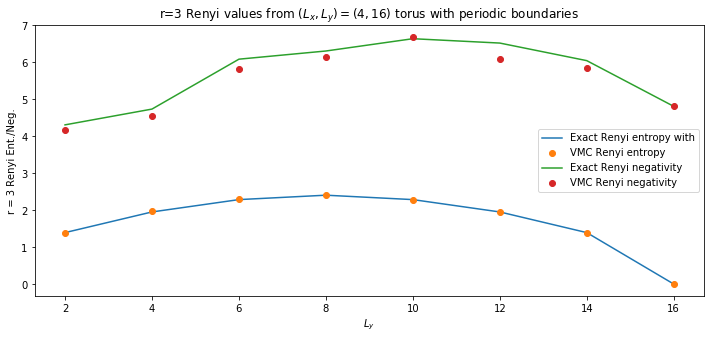

Averaged over 5 runs
Renyi entropy error of [-0.00363476  0.01726265  0.00163075 -0.00227408 -0.00210594 -0.00232299
 -0.00057258         inf]
Renyi negativity error of [[-0.03419456 -0.03968775 -0.04520685 -0.02606976  0.00714186 -0.06787155
  -0.03442334  0.0019632 ]]


In [53]:
Run += 1

Nr_ex_r3 += np.abs(Nr_ex)
Rr_ex_r3 += np.abs(Rr_ex)
Nr_vmc_r3 += np.abs(Nr_vmc)
Rr_vmc_r3 += np.abs(Rr_vmc)

N_error = (Nr_vmc_r3.T-Nr_ex_r3)/Nr_ex_r3
R_error = (Rr_vmc_r3.T-Rr_ex_r3)/Rr_ex_r3

fig = plt.figure(figsize=(12.0, 5.0))
axes1 = fig.add_subplot(1, 1, 1)
axes1.set_ylabel("r = %d Renyi Ent./Neg." %(r))
axes1.set_xlabel('$L_y$',fontsize=10)


axes1.plot( Ly_list, Rr_ex_r3/Run, label = 'Exact Renyi entropy with')
axes1.plot( Ly_list, Rr_vmc_r3/Run, 'o',label = 'VMC Renyi entropy')
axes1.plot( Ly_list, Nr_ex_r3/Run,label = 'Exact Renyi negativity')
axes1.plot( Ly_list, Nr_vmc_r3/Run, 'o',label = 'VMC Renyi negativity')
axes1.legend()

plt.title('r=%d Renyi values from $(L_x,L_y) = (4,16) $ torus with periodic boundaries' % (r) )


plt.show()
print("Averaged over %d runs" % (Run))
print("Renyi entropy error of", R_error)
print("Renyi negativity error of", N_error)

In [45]:
print(Nr_ex_r3,Nr_vmc_r3.T)

[4.30600982 4.73285435 6.08281017 6.30387526 6.63642698 6.51854816
 6.04311682 4.80681808] [[4.169836  4.579008  5.744689  5.8319864 6.8780093 6.4025583 5.843194
  4.822482 ]]
